In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

from torchvision import models,transforms
import copy

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
#Loading the images

#desired size of the output image
imsize=400 if torch.cuda.is_available() else 128
loader=transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])
def image_loader(image_name):
    image=Image.open(image_name)
    #fake batch dimensions required to fit network's input dimensions
    image=loader(image).unsqueeze(0)
    return image.to(device,torch.float)
style_image=image_loader('./images/picasso.jpg')
content_image=image_loader('./images/dancing.jpg')
assert style_image.size()==content_image.size(),"we need to import style and content iamge of the same size"

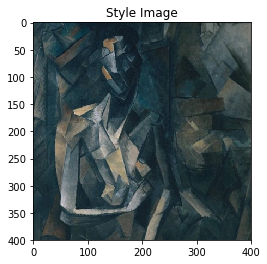

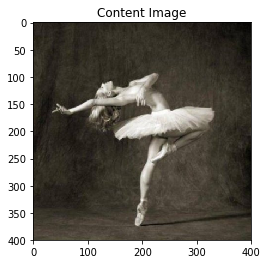

In [3]:
#Display an image
unloader=transforms.ToPILImage()   #reconvert to PIL image
plt.ion()
def imshow(image,title=None):
    image=image.cpu().clone()   #clone the tensor-image to cpu
    image=image.squeeze(0)     #remove fake batch dimensions
    image=unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
plt.figure()
imshow(style_image,title='Style Image')
plt.figure()
imshow(content_image,title='Content Image')

In [11]:
#Content loss
class ContentLoss(nn.Module):
    def __init__(self,target):
        super(ContentLoss,self).__init__()
        #from the tree分离出目标内容动态计算梯度
        self.target=target.detach()
    def forward(self,input):
        self.loss=F.mse_loss(input,self.target)
        return input

In [12]:
#Style loss

#计算gram matrix
def gram_matrix(input):
    #a=batch size(=1) b=number of feature maps (c,d)=dimensions of f. map(N=c*d)
    a,b,c,d=input.size()
    #resize F_XL
    features=input.view(a*b,c*d)
    #计算gram matrix的乘积
    G=torch.mm(features,features.t())
    #normalize gram matrix.除以feature maps的元素个数
    return G.div(a*b*c*d)
class StyleLoss(nn.Module):
    def __init__(self,target_feature):
        super(StyleLoss,self).__init__()
        self.target=gram_matrix(target_feature).detach()
    def forward(self,input):
        G=gram_matrix(input)
        self.loss=F.mse_loss(G,self.target)
        return input


In [13]:
#Importing the model.use a 19layers VGG
cnn=models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std=torch.tensor([0.229, 0.224, 0.225]).to(device)

#create a module to normalize input image
class Normalization(nn.Module):
    def __init__(self,mean,std):
        super(Normalization,self).__init__()
        #将mean and std变换成(c,1,1)，以便直接用于tensor image(n,c,h,w)
        self.mean=torch.tensor(mean).view(-1,1,1)
        self.std=torch.tensor(std).view(-1,1,1)
    def forward(self,img):
        #normalize image
        return (img-self.mean)/self.std

#在合适的层计算Content/Style loss
content_layers_default=['conv_4']
style_layers_default=['conv_1','conv_2','conv_3','conv_4','conv_5']
#将Content/Style loss的计算Module加入到VGG网络中
def get_style_model_and_loss(cnn,normalization_mean,normalization_std,style_img,content_img,
                            content_layers=content_layers_default,style_layers=style_layers_default):
    cnn=copy.deepcopy(cnn)
    #normalization module，输出层
    normalization=Normalization(normalization_mean,normalization_std).to(device)
    #记录Content/Style loss
    content_losses=[]
    style_losses=[]
    #创建新的网络，将各module添加进去
    model=nn.Sequential(normalization)
    i=0    #每经过一个卷积层加一
    for layer in cnn.children():
        if isinstance(layer,nn.Conv2d):
            i+=1
            name='conv_{}'.format(i)
        elif isinstance(layer,nn.ReLU):
            name='relu_{}'.format(i)
            #将in_place替换成out_of_place
            layer=nn.ReLU(inplace=False)
        elif isinstance(layer,nn.MaxPool2d):
            name='pool_{}'.format(i)
        elif isinstance(layer,nn.BatchNorm2d):
            name='bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecongnized layer: {}'.format(layer.__class__.__name__))
        model.add_module(name,layer)
        #add content loss 模块
        if name in content_layers:
            target=model(content_img).detach()
            content_loss=ContentLoss(target)
            model.add_module('content_loss_{}'.format(i),content_loss)
            content_losses.append(content_loss)
        #add style loss 模块
        if name in style_layers:
            target_feature=model(style_img).detach()
            style_loss=StyleLoss(target_feature)
            model.add_module('style_loss_{}'.format(i),style_loss)
            style_losses.append(style_loss)
    #修剪last ContentLoss和StyleLoss之后的层
    for i in range(len(model)-1,-1,-1):
        if isinstance(model[i],ContentLoss) or isinstance(model[i],StyleLoss):
            break
    model=model[:(i+1)]
    return model,style_losses,content_losses
#model_show=get_style_model_and_loss(cnn,cnn_normalization_mean,cnn_normalization_std,style_image,content_image)
#print(model_show)

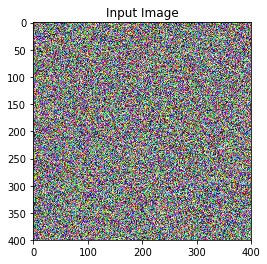

In [14]:
#选择输入图像，content_image或white noise
input_img=content_image.clone()
#use white noise
input_img1=torch.randn(content_image.data.size(),device=device)
plt.figure()
imshow(input_img1,title='Input Image')

Build the style transfer model。。。。


C:\Users\13051\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
C:\Users\13051\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Optimizing.....
run[50]:
Style Loss: 5.2242 Content Loss: 4.8649

run[100]:
Style Loss: 1.3848 Content Loss: 3.3444

run[150]:
Style Loss: 0.8055 Content Loss: 2.8430

run[200]:
Style Loss: 0.5371 Content Loss: 2.6359

run[250]:
Style Loss: 0.3946 Content Loss: 2.5242

run[300]:
Style Loss: 0.3102 Content Loss: 2.4558



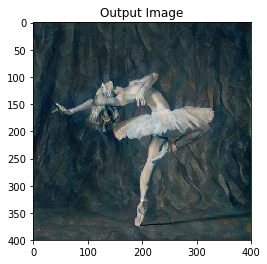

In [15]:
#梯度下降函数，we want to训练输入图像最小化content/style loss
def get_input_optimizer(input_img):
    optimizer=optim.LBFGS([input_img.requires_grad_()])
    return optimizer

#每次迭代，传入更新后的图片计算新的losses
def run_style_transfer(cnn,normalization_mean,normalization_std,content_img,style_img,input_img,
                      num_steps=300,style_weight=1000000,content_weight=1):
    print('Build the style transfer model。。。。')
    model,style_losses,content_losses=get_style_model_and_loss(cnn,normalization_mean,normalization_std,style_img,content_img)
    optimizer=get_input_optimizer(input_img)
    print('Optimizing.....')
    run=[0]
    while run[0]<=num_steps:
        def closure():   #correct the values of updated input image
            input_img.data.clamp_(0,1)
            optimizer.zero_grad()
            model(input_img)
            style_score=0
            content_score=0
            for sl in style_losses:
                style_score+=sl.loss
            for cl in content_losses:
                content_score+=cl.loss
            style_score*=style_weight
            content_score*=content_weight
            loss=style_score+content_score
            loss.backward()
            
            run[0]+=1
            if run[0]%50==0:
                print('run{}:'.format(run))
                print('Style Loss: {:.4f} Content Loss: {:.4f}'.format(style_score.item(),content_score.item()))
                print()
            return style_score+content_score
        optimizer.step(closure)
    #a last correction...
    input_img.data.clamp_(0,1)
    return input_img
#run Neural style transfer algorithm
output=run_style_transfer(cnn,cnn_normalization_mean,cnn_normalization_std,content_image,style_image,input_img)
plt.figure()
imshow(output,title='Output Image')
plt.ioff()
plt.show()